In [164]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import linregress
from matplotlib.patches import Rectangle
from plot import load_logs, plot_runs, add_values_from_normal_runs, PV_MAP
# refresh files

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
from matplotlib.font_manager import fontManager, FontProperties
path = "/home/getznerj/Downloads/Palatino Font Free/Palatino.ttf"
fontManager.addfont(path)
prop = FontProperties(fname=path)
plt.rcParams['font.family'] = prop.get_name()

In [166]:
TUM_colors =  {
    "TUMBlue": "#0065BD",
    "TUMSecondaryBlue": "#005293",
    "TUMSecondaryBlue2": "#003359",
    "TUMBlack": "#000000",
    "TUMWhite": "#FFFFFF",
    "TUMDarkGray": "#333333",
    "TUMGray": "#808080",
    "TUMLightGray": "#CCCCC6",
    "TUMAccentGray": "#DAD7CB",
    "TUMAccentOrange": "#E37222",
    "TUMAccentGreen": "#A2AD00",
    "TUMAccentLightBlue": "#98C6EA",
    "TUMAccentBlue": "#64A0C8"
}

In [167]:
BASE_DIR = "/home/getznerj/Documents/Thesis/Thesis Final Experiments"

In [168]:
log_dir = os.path.join(BASE_DIR, "baseline")
data = load_logs(log_dir = log_dir)
data_age = {key: value for key, value in data.items() if "age" in key}
data_sex = {key: value for key, value in data.items() if "sex" in key}

In [169]:
melted_dfs = []
percent_subset = [0, 0.25, 0.5, 0.75, 1]
metrics = []
for key, df in data_age.items():
    metrics = [col for col in df.columns if "subgroup" in col]
    dp = df.iloc[0].dp
    pv = "age" if "age" in key else "sex"
    df = df[["protected_attr", "protected_attr_percent", "seed"] + metrics]
    df = df.loc[df.protected_attr_percent.isin(percent_subset)]
    df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
    metrics = [PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics]
    df = df.melt(id_vars=["protected_attr", "protected_attr_percent", "seed"], value_vars=metrics, var_name="metric", value_name="value")
    df["value"] = df["value"] * 100
    df["protected_attr_percent"] = (df["protected_attr_percent"] * 100).astype(int)
    if dp:
        df["metric"] = df["metric"] + " (DP)"
    melted_dfs.append(df)
metrics += [m + " (DP)" for m in metrics]
df = pd.concat(melted_dfs)

Slope for young is -0.092 with p-value 0.000 
Slope for old is 0.046 with p-value 0.000 
Slope for young (DP) is -0.062 with p-value 0.000 
Slope for old (DP) is 0.035 with p-value 0.000 


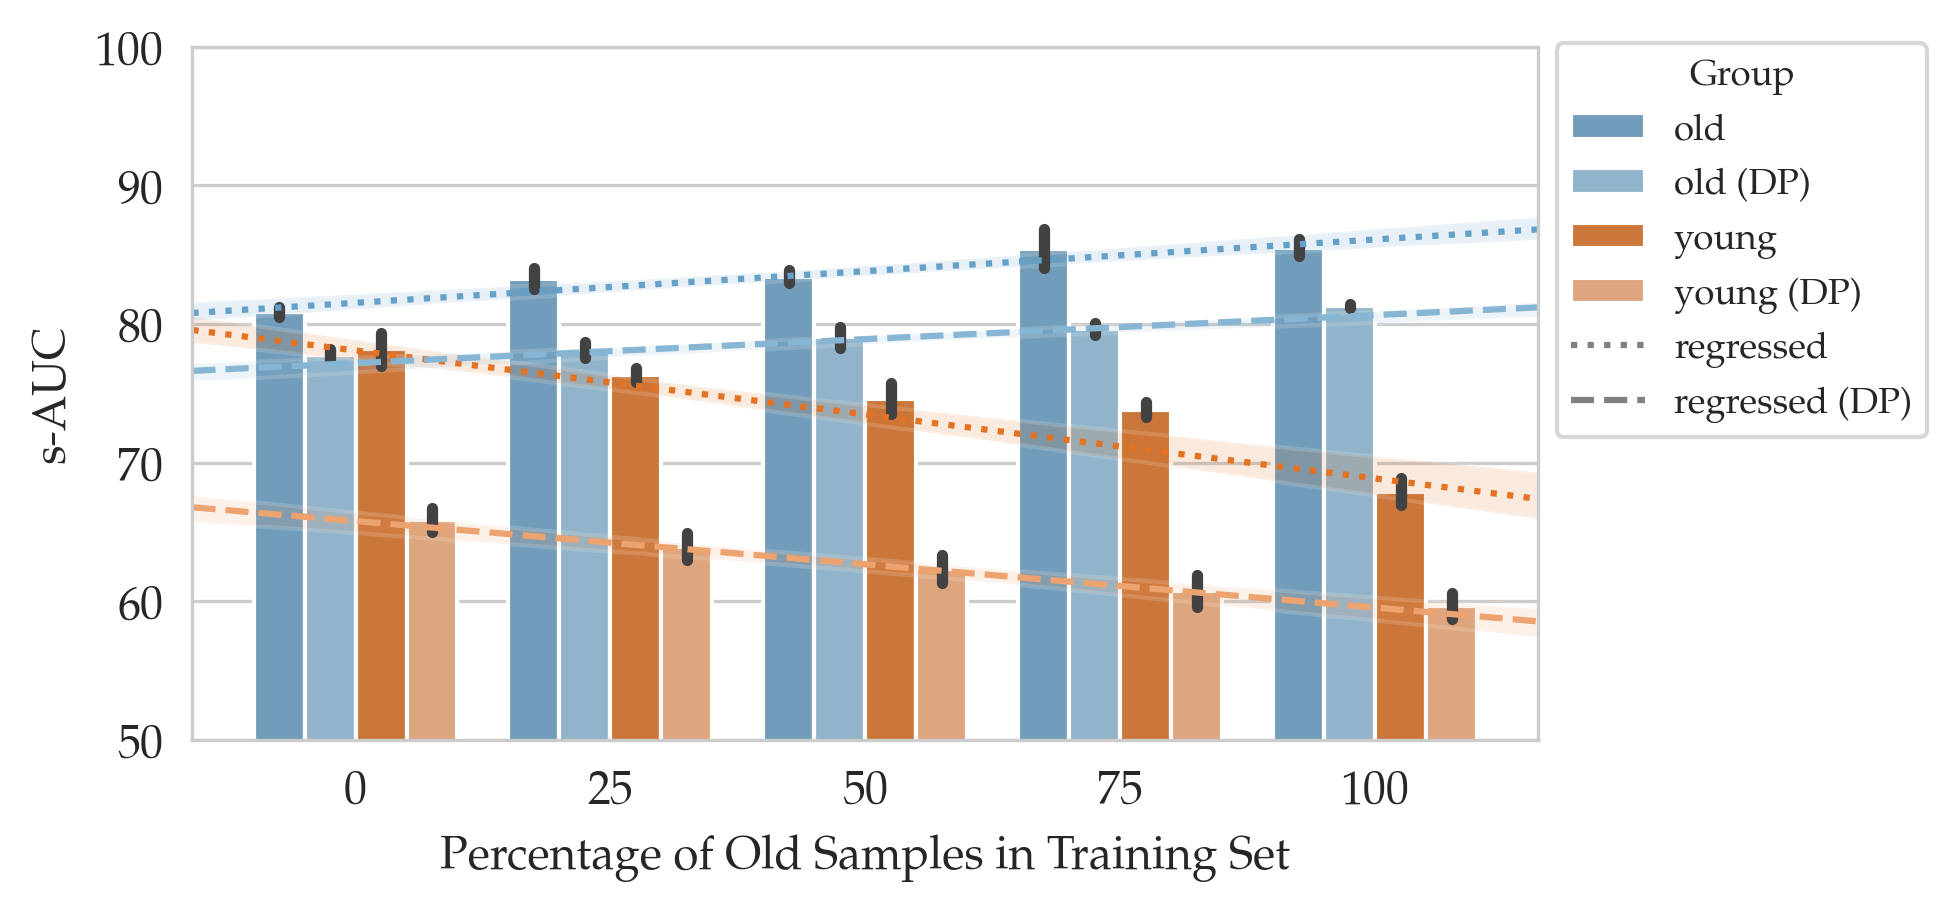

In [170]:
color_palette = {
    "old": TUM_colors["TUMAccentBlue"],
    "young": TUM_colors["TUMAccentOrange"],
    "old (DP)": "#87b6d4",
    "young (DP)": "#eda36f"
}
plt.figure(figsize=(5.78853, 3))
fontSize = 11
rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': fontSize, 'axes.titlesize': fontSize, 'font.size': fontSize, 'legend.fontsize': fontSize*0.8}
plt.rcParams.update(rc)
# no outline around bar
g = sns.barplot(data=df, x="protected_attr_percent", y="value", hue="metric", ci="sd", palette=color_palette, edgecolor=None, hue_order=["old", "old (DP)", "young", "young (DP)"])
# set ylim 
g.set(ylim=(50, 100))
# legend title
x_coords = sorted([patch.get_x() + patch.get_width() / 2 for patch in g.patches])
for idx, metric in enumerate(metrics):
    df_melted_sub = df[df[f"metric"] == metric]
    # choose every second value starting from idx (differentiate bars corresponding to different metrics)
    x_coords_sub = x_coords[idx::4]
    percent_values = sorted(df_melted_sub["protected_attr_percent"].unique())
    percent_to_x_coord = {p: x for p, x in zip(percent_values, x_coords_sub)}
    df_melted_sub.loc[:, "x_coord"] = df_melted_sub.loc[:, "protected_attr_percent"].map(percent_to_x_coord)
    slope, intercept, r_value, p_value, std_err = linregress(df_melted_sub["protected_attr_percent"],
                                                             df_melted_sub["value"])
    print(f"Slope for {metric} is {slope:.3f} with p-value {p_value:.3f} ")
    if p_value < 0.05 or True:
        line_label = f"{metric} regressed"
        color = color_palette[metric]
        sns.regplot(x="x_coord", y="value", data=df_melted_sub, scatter=False,
            line_kws={"color": color, "lw": 1.5, "ls": "--" if "DP" in metric else "dotted"}, truncate=False, ci=95)
reg_line_DP = plt.Line2D([0], [0], color=TUM_colors["TUMGray"], linestyle='--', label="DP regressed")
reg_line_normal = plt.Line2D([0], [0], color=TUM_colors["TUMGray"], linestyle='dotted', label="regressed")
handles, labels = g.get_legend_handles_labels()
handles.extend([reg_line_normal, reg_line_DP])
labels.extend(["regressed", "regressed (DP)"])
g.legend_.remove()
g.legend(handles, labels, title="Group", loc='lower left', bbox_to_anchor=(1.0, 0.41))
plt.setp(g.get_legend().get_title(), fontsize=fontSize*0.8)
plt.xlabel("Percentage of Old Samples in Training Set")
plt.ylabel("s-AUC")
plt.savefig("../plots/problem_age.png", bbox_inches='tight', dpi=300)

In [171]:
df.drop(columns=["protected_attr", "seed"], inplace=True)
df_mean = df.groupby(["metric", "protected_attr_percent"]).mean().reset_index()

In [172]:
# compute diff in means between male and female and male (DP) and female (DP)
for percent_val in df_mean.protected_attr_percent.unique():
    print(f"Percent: {percent_val}")
    sub = df_mean[df_mean.protected_attr_percent == percent_val]
    # compute diff in male and female
    print("diff normal:", sub.loc[sub.metric == "old"]["value"].item() - sub.loc[sub.metric == "young"]["value"].item())
    print("diff dp:", sub.loc[sub.metric == "old (DP)"]["value"].item() - sub.loc[sub.metric == "young (DP)"]["value"].item())
    #print("Diff:", sub.loc[sub.metric == "male"]["value"] - sub.loc[sub.metric == "female"]["value"])

Percent: 0
diff normal: 2.691999673843384
diff dp: 11.899999777475998
Percent: 25
diff normal: 6.936004161834717
diff dp: 14.166663090387985
Percent: 50
diff normal: 8.816003799438477
diff dp: 16.68666799863179
Percent: 75
diff normal: 11.619997024536133
diff dp: 18.926662206649773
Percent: 100
diff normal: 17.59999990463257
diff dp: 21.653332312901817


In [173]:
melted_dfs = []
percent_subset = [0, 0.25, 0.5, 0.75, 1]
metrics = []
for key, df in data_sex.items():
    metrics = [col for col in df.columns if "subgroup" in col]
    dp = df.iloc[0].dp
    pv = "age" if "age" in key else "sex"
    df = df[["protected_attr", "protected_attr_percent", "seed"] + metrics]
    df = df.loc[df.protected_attr_percent.isin(percent_subset)]
    df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
    metrics = [PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics]
    df = df.melt(id_vars=["protected_attr", "protected_attr_percent", "seed"], value_vars=metrics, var_name="metric", value_name="value")
    df["value"] = df["value"] * 100
    df["protected_attr_percent"] = (df["protected_attr_percent"] * 100).astype(int)
    if dp:
        df["metric"] = df["metric"] + " (DP)"
    melted_dfs.append(df)
metrics += [m + " (DP)" for m in metrics]
df = pd.concat(melted_dfs)

Slope for male is 0.056 with p-value 0.000 
Slope for female is -0.085 with p-value 0.000 
Slope for male (DP) is 0.082 with p-value 0.000 
Slope for female (DP) is -0.033 with p-value 0.000 


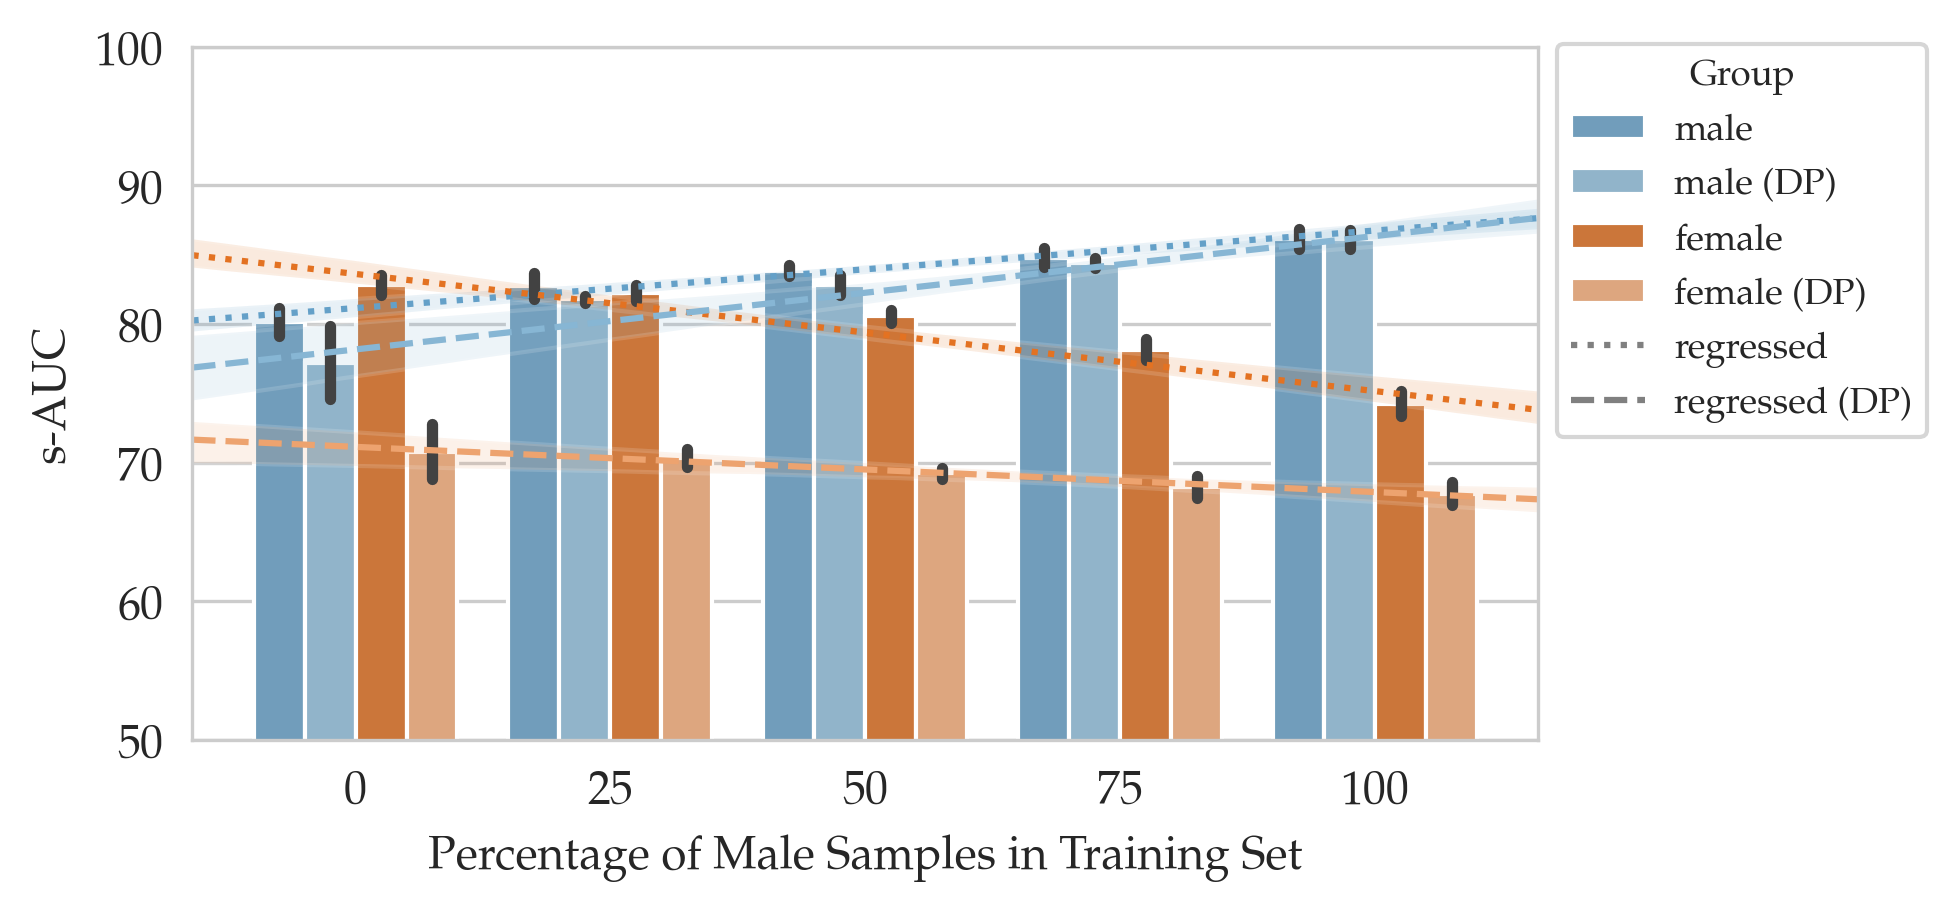

In [174]:
color_palette = {
    "male": TUM_colors["TUMAccentBlue"],
    "female": TUM_colors["TUMAccentOrange"],
    "male (DP)": "#87b6d4",
    "female (DP)": "#eda36f"
}
plt.figure(figsize=(5.78853, 3))
fontSize = 11
rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': fontSize, 'axes.titlesize': fontSize, 'font.size': fontSize, 'legend.fontsize': fontSize*0.8}
plt.rcParams.update(rc)
# no outline around bar
g = sns.barplot(data=df, x="protected_attr_percent", y="value", hue="metric", ci="sd", palette=color_palette, edgecolor=None, hue_order=["male", "male (DP)", "female", "female (DP)"])
# set ylim 
g.set(ylim=(50, 100))
# legend title
x_coords = sorted([patch.get_x() + patch.get_width() / 2 for patch in g.patches])

for idx, metric in enumerate(metrics):
    df_melted_sub = df[df[f"metric"] == metric]
    # choose every second value starting from idx (differentiate bars corresponding to different metrics)
    x_coords_sub = x_coords[idx::4]
    percent_values = sorted(df_melted_sub["protected_attr_percent"].unique())
    percent_to_x_coord = {p: x for p, x in zip(percent_values, x_coords_sub)}
    df_melted_sub.loc[:, "x_coord"] = df_melted_sub.loc[:, "protected_attr_percent"].map(percent_to_x_coord)
    slope, intercept, r_value, p_value, std_err = linregress(df_melted_sub["protected_attr_percent"],
                                                             df_melted_sub["value"])
    print(f"Slope for {metric} is {slope:.3f} with p-value {p_value:.3f} ")
    if p_value < 0.05 or True:
        line_label = f"{metric} regressed"
        color = color_palette[metric]
        sns.regplot(x="x_coord", y="value", data=df_melted_sub, scatter=False,
            line_kws={"color": color, "lw": 1.5, "ls": "--" if "DP" in metric else "dotted"}, truncate=False, ci=95)
reg_line_DP = plt.Line2D([0], [0], color=TUM_colors["TUMGray"], linestyle='--', label="DP regressed")
reg_line_normal = plt.Line2D([0], [0], color=TUM_colors["TUMGray"], linestyle='dotted', label="regressed")
handles, labels = g.get_legend_handles_labels()
handles.extend([reg_line_normal, reg_line_DP])
labels.extend(["regressed", "regressed (DP)"])
g.legend_.remove()
# legend outside
g.legend(handles, labels, title="Group", loc='lower left', bbox_to_anchor=(1.0, 0.41))
plt.setp(g.get_legend().get_title(), fontsize=fontSize*0.8)
plt.xlabel("Percentage of Male Samples in Training Set")
plt.ylabel("s-AUC")
# save figure
plt.savefig("../plots/problem_sex.png", bbox_inches='tight', dpi=300)

In [175]:
df.drop(columns=["protected_attr", "seed"], inplace=True)
df_mean = df.groupby(["metric", "protected_attr_percent"]).mean().reset_index()

In [176]:
# compute diff in means between male and female and male (DP) and female (DP)
for percent_val in df_mean.protected_attr_percent.unique():
    print(f"Percent: {percent_val}")
    sub = df_mean[df_mean.protected_attr_percent == percent_val]
    # compute diff in male and female
    print("diff normal:", sub.loc[sub.metric == "male"]["value"].item() - sub.loc[sub.metric == "female"]["value"].item())
    print("diff dp:", sub.loc[sub.metric == "male (DP)"]["value"].item() - sub.loc[sub.metric == "female (DP)"]["value"].item())
    #print("Diff:", sub.loc[sub.metric == "male"]["value"] - sub.loc[sub.metric == "female"]["value"])

Percent: 0
diff normal: -2.6440012454986572
diff dp: 6.413336594899491
Percent: 25
diff normal: 0.5240046977996826
diff dp: 11.473337809244796
Percent: 50
diff normal: 3.2919979095458984
diff dp: 13.58000636100769
Percent: 75
diff normal: 6.627997159957886
diff dp: 16.17332895596823
Percent: 100
diff normal: 11.86400294303894
diff dp: 18.36666464805603
